In [1]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import minilensmaker as mil

In [2]:
# Download and unzip the COSMOS data from https://zenodo.org/record/3242143
# then update the path below to point to the folder containing all the files.
catalog = mil.COSMOSCatalog('/home/jaalbers/software/manada/datasets/cosmos/COSMOS_23.5_training_sample')

# Select some nice galaxies

The COSMOS catalog contains many images. Some of these are 'bad' in various ways:
  * Some contain only a poiunt source. This isn't very interesting to reconstruct. 
  * Some have a very poor signal/noise, perhaps because the galaxy is far away (high redshift) or very faint (high magnitude).
  * Some have huge areas masked out (pixels set to zero) by a foreground star removal algorithm. Unfortunately this data (as far I know) no longer has the details of which images were most affected by that algorithm...

You will probably want to experiment with different selections, or maybe make a manual 'blacklist'. Here is a simple magnitude/redshift selection.

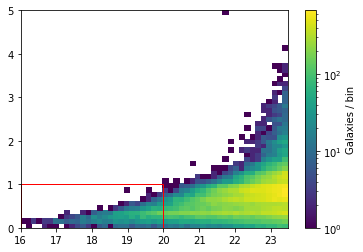

In [42]:
magnitude_range = (16, 20)
redshift_range = (0, 1)

x, y = catalog.catalog['mag_auto'], catalog.catalog['zphot'], 
plt.hist2d(x, y,
           bins=(np.linspace(16, 23.5, 50), np.linspace(0, 5, 50)), 
           norm=matplotlib.colors.LogNorm());
plt.colorbar(label='Galaxies / bin')

mil.draw_box(magnitude_range, redshift_range, edgecolor='r')

selection_mask = (
    (magnitude_range[0] <= x) & (x < magnitude_range[1])
    & (redshift_range[0] <= y) & (y < redshift_range[1]))

# Draw metadata

In [47]:
n_images = 10

md = dict()

# Index in the catalog of the galaxy image to use
md['source_index'] = catalog.sample_indices(n_images, selection_mask)

# Rotation (in radians) to give the source image
md['source_rotation'] = 2 * np.pi * np.random.rand(n_images)

# Einstein radius in arcseconds of the lens
md['theta_E'] = np.random.uniform(0.8, 1.2, n_images)

# Exponent of the lens's power-law mass distribution
md['gamma'] = 2 + 0.1 * np.random.randn(n_images)

# Ellipticity components of the lens
md['e1'], md['e2'] = np.random.uniform(-0.05, 0.05, (2, n_images))

# Location of the lens in the image, in arcseconds
md['center_x'], md['center_y'] = 0.2 * np.random.randn(2, n_images)

# External shear components
md['gamma1'], md['gamma2'] = 0.16 * np.random.randn(2, n_images)

# You can save this to csv, or whatever other output you prefer
pd.DataFrame(md)

,source_index,source_rotation,theta_E,gamma,e1,e2,center_x,center_y,gamma1,gamma2
0,18008,1.213964,0.879058,2.042190,0.033192,-0.038942,-0.210745,0.020673,0.023460,0.064979
1,4693,4.322868,0.985235,1.772651,0.042809,-0.039039,0.010961,-0.127250,-0.045423,-0.038790
2,38290,0.290931,1.175605,1.918032,0.001589,-0.031372,-0.094675,0.032239,0.166086,-0.019441
3,4304,4.228492,1.021301,1.870715,0.005077,-0.008554,-0.111470,-0.151643,-0.197048,0.178640
4,16716,5.755263,1.149852,2.114177,0.036527,0.008626,-0.032540,0.059717,-0.074841,0.291556
5,8200,3.997024,0.991642,1.860609,0.015129,0.006698,-0.016152,-0.041606,0.068287,0.105604
6,22690,4.980464,0.866245,2.023168,-0.000575,0.018602,-0.179841,0.401460,-0.051292,0.016339
7,40968,3.529089,1.155459,2.164898,0.028398,-0.004984,0.050564,-0.085112,-0.154128,0.069659
8,4768,2.606194,1.016253,1.967528,0.043409,0.013308,0.074601,0.152025,-0.142384,-0.101304
9,55303,6.121091,0.803924,2.000020,-0.019357,0.032075,0.117986,0.446765,-0.032065,0.197588


### Produce images

In [48]:
lensmaker = mil.LensMaker(catalog=catalog, pixel_width=0.08)

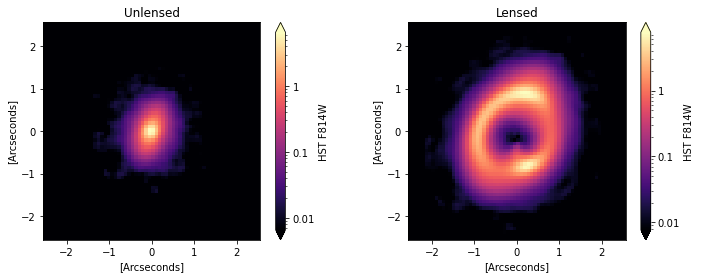

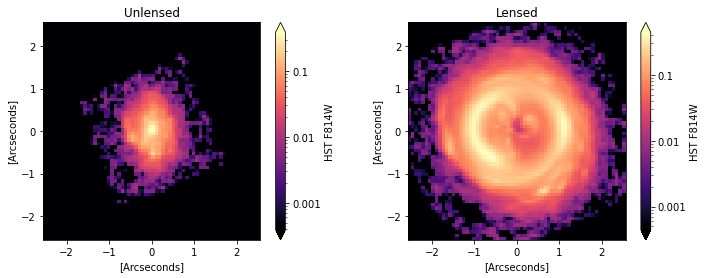

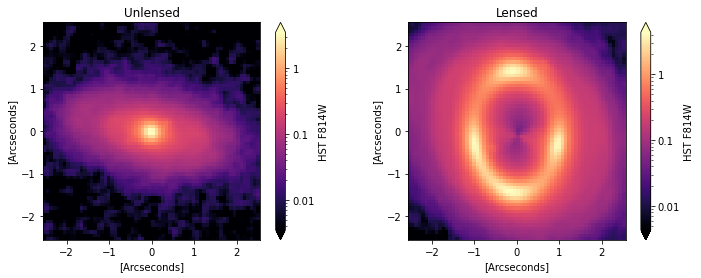

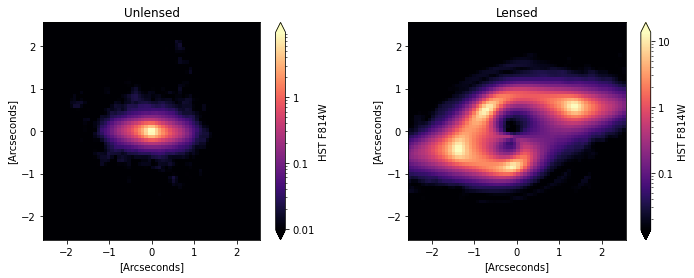

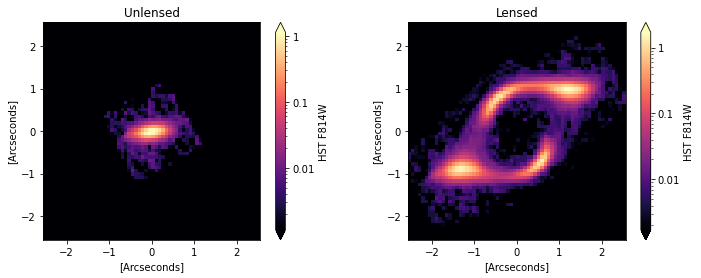

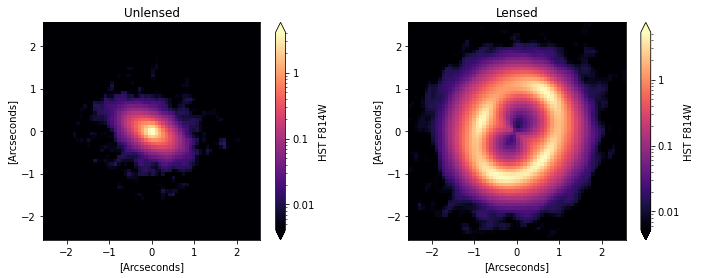

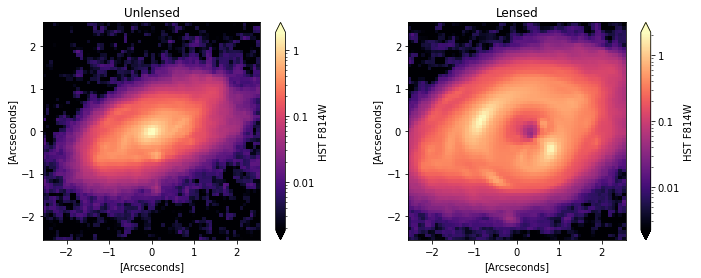

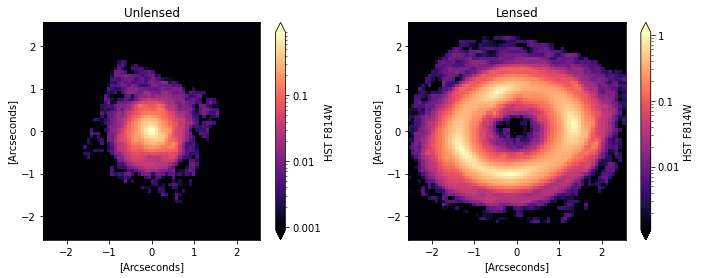

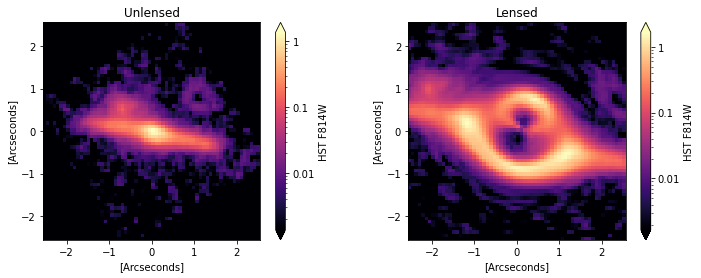

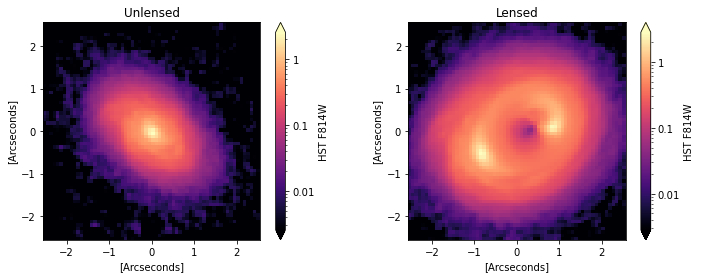

In [49]:
plot = True
# A dummy 'lens' that does not lens at all.
no_lens = [('SIS', dict(theta_E=0))]

for i in range(n_images):

    source_kwargs = dict(
        catalog_i=md['source_index'][i], 
        phi=md['source_rotation'][i])
    
    unlensed_img = lensmaker.lensed_image(
        lenses=no_lens,
        **source_kwargs)
    
    lensed_img = lensmaker.lensed_image(
        lenses=[
            ('PEMD', {k: md[k][i] for k in 'theta_E gamma e1 e2 center_x center_y'.split()}),
            ('SHEAR', {k: md[k][i] for k in 'gamma1 gamma2'.split()})],
        **source_kwargs)
    
    # Here you would save these images in whatever format you prefer.
    # Be aware these images are now arrays of floats; most image formats are made of integers.
    # Unless you use a float-image format (or just save the numpy array),
    # you will either have to commit to some discretization and normalization here.
    
    if plot:
        f, axes = plt.subplots(ncols=2, figsize=(12, 4))
        
        plt.sca(axes[0])
        mil.plot_image(
            unlensed_img,
            lensmaker.pixel_width)
        plt.title("Unlensed")
        
        plt.sca(axes[-1])
        mil.plot_image(
            lensed_img,
            lensmaker.pixel_width)
        plt.title("Lensed")